In [1]:
import torch
import os
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne, tensors_as_images, dataset_first_n
import numpy as np
import random
import argparse
import itertools

import IPython.display


import nets
import training

NUM_CLASSES = 10

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [3]:
args = argparse.Namespace()
args.seed = 0
args.data_path = "/datasets/cv_datasets/data"
args.batch_size = 32
args.latent_dim = 128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.mnist = False
args.self_supervised = False

In [4]:
freeze_seeds(args.seed)

In [5]:

if args.mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  
    ])
    train_dataset = datasets.MNIST(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=args.data_path, train=False, download=True, transform=transform)
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
    ])
    train_dataset = datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


(<Figure size 1000x1000 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

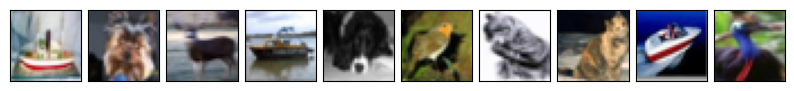

In [6]:

dataset_first_n(train_dataset, 10, figsize=(10,10), nrows=1)

In [7]:


#Data
# When you create your dataloader you should split train_dataset or test_dataset to leave some aside for validation
ds_val, ds_train = torch.utils.data.random_split(train_dataset, [0.2, 0.8])

# ds_train = torch.utils.data.Subset(ds_train, range(100))


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=args.batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

dl_sample = itertools.cycle(torch.utils.data.DataLoader(ds_train, batch_size=5, shuffle=True))

img_shape = train_dataset[0][0].shape

#Model
# encoder_model = torch.nn.Linear(32*32*3,args.latent_dim).to(args.device)
# decoder_model = torch.nn.Linear(args.latent_dim,32*32*3 if args.self_supervised else NUM_CLASSES).to(args.device) 
model = nets.AE(img_shape, args.latent_dim).to(args.device)
model_dp = torch.nn.DataParallel(model)

#Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-1, weight_decay = 1e-8)

#Loss
loss_fn = torch.nn.MSELoss()

#Trainer
trainer = training.AETrainer(model_dp, loss_fn, optimizer, args.device)
checkpoint_file = 'checkpoints/cifar_ae'
checkpoint_file_final = f'{checkpoint_file}_final'
# if os.path.isfile(f'{checkpoint_file}.pt'):
#     os.remove(f'{checkpoint_file}.pt')




In [ ]:
def post_epoch_fn(epoch, train_result, test_result, verbose):
    # Plot some samples if this is a verbose epoch
    if verbose:
        imgs, _ = next(dl_sample)
        imgs = imgs.to(args.device)
        recon_imgs = model.sample(imgs)

        fig, _ = tensors_as_images(list(imgs), figsize=(6,3))
        IPython.display.display(fig)
        plt.close(fig)

        fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3))
        IPython.display.display(fig)
        plt.close(fig)

: 

c:\Users\matan\Desktop\Studies\deep learning\hw\project\training.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(checkpoint_filename, map_locat

*** Loading checkpoint file checkpoints/cifar_ae.pt
--- EPOCH 1/200 ---
test_batch (Avg. Loss 0.113, Accuracy 27.8): 100%|██████████| 313/313 [00:23<00:00, 13.47it/s]
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 1


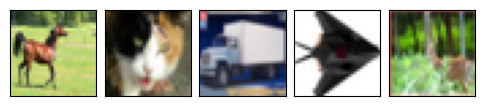

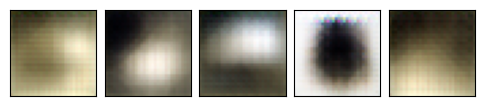

--- EPOCH 2/200 ---
test_batch (Avg. Loss 0.286, Accuracy 11.0): 100%|██████████| 313/313 [00:23<00:00, 13.53it/s]


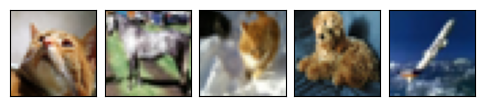

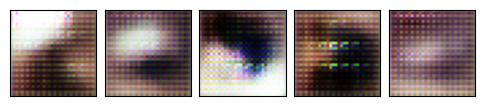

--- EPOCH 3/200 ---
test_batch (Avg. Loss 0.081, Accuracy 38.9): 100%|██████████| 313/313 [00:27<00:00, 11.28it/s]
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 3


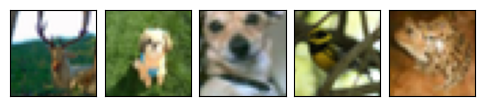

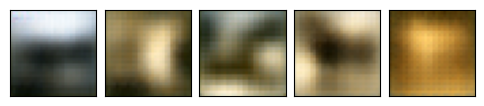

--- EPOCH 4/200 ---
test_batch (Avg. Loss 0.073, Accuracy 43.0): 100%|██████████| 313/313 [00:23<00:00, 13.12it/s]
*** Saved checkpoint checkpoints/cifar_ae.pt at epoch 4


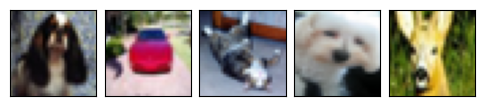

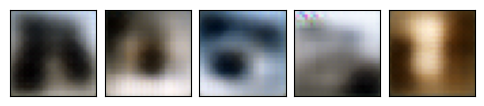

--- EPOCH 5/200 ---
train_batch (0.074):  10%|▉         | 120/1250 [00:38<06:05,  3.09it/s]

In [ ]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=200, early_stopping=20, print_every=1,
                      checkpoints=checkpoint_file,
                      post_epoch_fn=post_epoch_fn)